In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px
import optuna
import sys
sys.path.append("../models + metrics/")
import diffusion_map
from kMeans import kMeans
from clustering_metrics import intrinsic_metrics, extrinsic_metrics

In [4]:
data = pd.read_csv("../data/politifact_all.csv")
data

,Unnamed: 0,id,news_url,title,tweet_ids,label
0,0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0
...,...,...,...,...,...,...
1051,619,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,1
1052,620,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,1
1053,621,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,1
1054,622,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,1


In [5]:
flat_embeddings = np.load("../data/politifact_embeddings.npy")
num_cols = int(flat_embeddings.size / len(data))
X = flat_embeddings.reshape(len(data), int(num_cols))
X.shape

(1056, 384)

In [6]:
ground_truths = data.label

In [5]:
def objective(trial):
    dim = trial.suggest_int("num_components", 1, 20)
    num_clusters = trial.suggest_int("k", 2, 10)
    #PCA
    pca = PCA(n_components=dim)
    pca_data = pca.fit_transform(X)  
    #cluster
    clusterer = kMeans(k=num_clusters)
    clusterer.train(pca_data, ground_truths)
    predict_labels = clusterer.labels
    # rand score
    return metrics.rand_score(ground_truths, predict_labels)

In [6]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-01 21:43:12,607] A new study created in memory with name: no-name-d37634b0-a313-4978-aa8a-bf23d809bb77
[I 2022-06-01 21:43:19,796] Trial 0 finished with value: 0.631044449231653 and parameters: {'num_components': 14, 'k': 3}. Best is trial 0 with value: 0.631044449231653.
[I 2022-06-01 21:43:23,606] Trial 1 finished with value: 0.7144406146775815 and parameters: {'num_components': 17, 'k': 2}. Best is trial 1 with value: 0.7144406146775815.
[I 2022-06-01 21:43:49,444] Trial 2 finished with value: 0.5264559098089904 and parameters: {'num_components': 16, 'k': 10}. Best is trial 1 with value: 0.7144406146775815.
[I 2022-06-01 21:44:17,313] Trial 3 finished with value: 0.5438891282493178 and parameters: {'num_components': 16, 'k': 8}. Best is trial 1 with value: 0.7144406146775815.
[I 2022-06-01 21:44:35,691] Trial 4 finished with value: 0.55386507252621 and parameters: {'num_components': 15, 'k': 6}. Best is trial 1 with value: 0.7144406146775815.
[I 2022-06-01 21:44:39,152] T

[I 2022-06-01 21:50:28,855] Trial 44 finished with value: 0.6313783570300158 and parameters: {'num_components': 9, 'k': 3}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:50:31,883] Trial 45 finished with value: 0.7169323567427833 and parameters: {'num_components': 7, 'k': 2}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:50:38,148] Trial 46 finished with value: 0.6149307051558236 and parameters: {'num_components': 7, 'k': 3}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:51:02,573] Trial 47 finished with value: 0.5248599741490737 and parameters: {'num_components': 10, 'k': 9}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:51:06,395] Trial 48 finished with value: 0.7181836133850352 and parameters: {'num_components': 5, 'k': 2}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:51:18,843] Trial 49 finished with value: 0.561189501651587 and parameters: {'num_components': 5, 'k': 5}. Best is trial 5 

[I 2022-06-01 21:54:34,036] Trial 89 finished with value: 0.7132001292546316 and parameters: {'num_components': 4, 'k': 2}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:54:37,629] Trial 90 finished with value: 0.7181836133850352 and parameters: {'num_components': 5, 'k': 2}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:54:41,453] Trial 91 finished with value: 0.7181836133850352 and parameters: {'num_components': 5, 'k': 2}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:54:44,741] Trial 92 finished with value: 0.6914853511417492 and parameters: {'num_components': 3, 'k': 2}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:54:47,795] Trial 93 finished with value: 0.7181836133850352 and parameters: {'num_components': 5, 'k': 2}. Best is trial 5 with value: 0.7181836133850352.
[I 2022-06-01 21:54:51,571] Trial 94 finished with value: 0.7181836133850352 and parameters: {'num_components': 6, 'k': 2}. Best is trial 5 

In [7]:
print("Best hyperparameters are:", study.best_params)
print("Best score is:", study.best_value)

Best hyperparameters are: {'num_components': 6, 'k': 2}
Best score is: 0.7181836133850352


In [7]:
pca = PCA(n_components=6)
pca_data = pca.fit_transform(X)  

In [8]:
clusterer = kMeans(k=2)
clusterer.train(pca_data, ground_truths)
predict_labels = clusterer.labels

In [9]:
intrinsic_metrics(X, predict_labels)

Sillhouette score: 0.025502354
Calinski-Harabasz Index: 27.592487943039863
Davies-Bouldin Index: 6.1692086297194475


[0.025502354, 27.592487943039863, 6.1692086297194475]

In [10]:
extrinsic_metrics(ground_truths, predict_labels)

Random Index: 0.7181836133850352
Homogeneity: 0.3608748074399187


[0.7181836133850352, 0.3608748074399187]

In [11]:
data.label[predict_labels==0].value_counts()

1    496
0     51
Name: label, dtype: int64

In [12]:
data.label[predict_labels==1].value_counts()

0    381
1    128
Name: label, dtype: int64

In [13]:
label_0_text = data.title[predict_labels==0]
label_1_text = data.title[predict_labels==1]

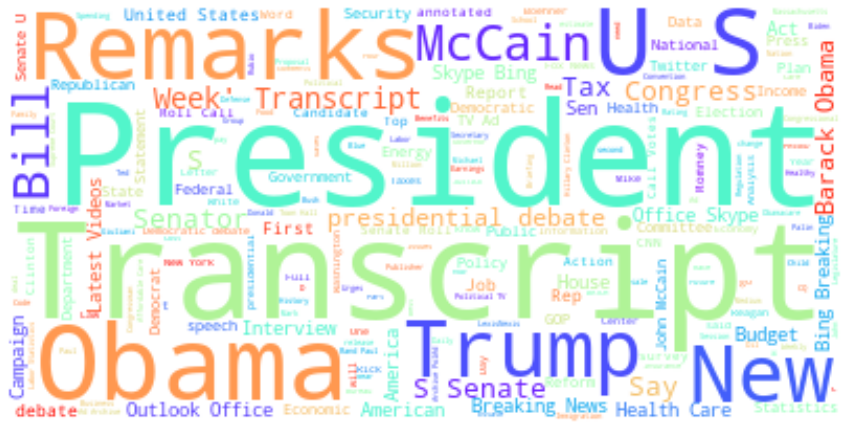

In [15]:
# cluster for true
text = " ".join(i for i in label_0_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color = 'white', colormap='rainbow').generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

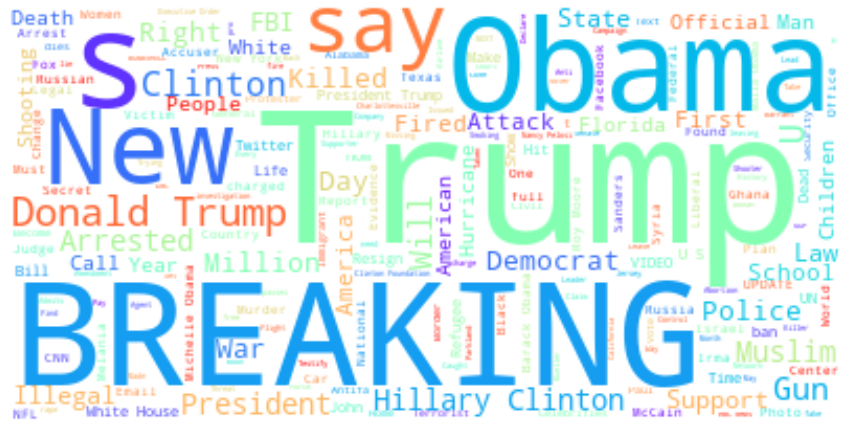

In [16]:
# cluster for false
text = " ".join(i for i in label_1_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap="rainbow").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()